In [1]:
# !pip install --quiet langchain-community 
# !pip install --quiet langchain-experimental langchain-openai 
# !pip install --quiet graphdatascience tiktoken retry neo4j
# !pip install --quiet matplotlib pandas numpy seaborn

## Graph RAG using Neo4j and Graph Datascience library

In [2]:
import os
import pandas as pd
import tiktoken
from langchain_community.graphs import Neo4jGraph
from tqdm import tqdm
import numpy as np
import re

pd.set_option('display.max_columns', None)

In [3]:
os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "Password@123"
graph = Neo4jGraph()

In [4]:
data = pd.read_csv("flipkart_product.csv", encoding="latin1")
# remove special characters from ProductName
# Using regex to replace all special characters with a space
spl_chars = '[!@#$%^&*()\[\]{};:,./<>?\|`~\-=_+]'
data["ProductName"] = data["ProductName"].apply(lambda x: re.sub(spl_chars, ' ', x))
data["Price"] = data["Price"].apply(lambda x: re.sub(spl_chars, ' ', str(x)))
data["Summary"] = data["Summary"].apply(lambda x: re.sub(spl_chars, ' ', str(x)))
# extract number from price
data["Price"] = data["Price"].apply(lambda x: re.findall(r'\d+', x))
data.head()

,ProductName,Price,Rate,Review,Summary
0,Candes 12 L Room Personal Air Cooler ÿ ÿ White...,"[3, 999]",5,Super!,Great cooler excellent air flow and for this...
1,Candes 12 L Room Personal Air Cooler ÿ ÿ White...,"[3, 999]",5,Awesome,Best budget 2 fit cooler Nice cooling
2,Candes 12 L Room Personal Air Cooler ÿ ÿ White...,"[3, 999]",3,Fair,The quality is good but the power of air is de...
3,Candes 12 L Room Personal Air Cooler ÿ ÿ White...,"[3, 999]",1,Useless product,Very bad product it's a only a fan
4,Candes 12 L Room Personal Air Cooler ÿ ÿ White...,"[3, 999]",3,Fair,Ok ok product


In [5]:
# data['Match_id'].value_counts().sort_values(ascending=True)
# Match 3495290 has the less number of rows

In [6]:
def get_token_count(text, model='gpt-4o'):
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(text))
    return num_tokens
data['token_count'] = [get_token_count(f"{row['ProductName']} {row['Summary']}") for i, row in data.iterrows()]

<Axes: title={'center': 'Token Count Distribution'}, xlabel='Token Count', ylabel='Frequency'>

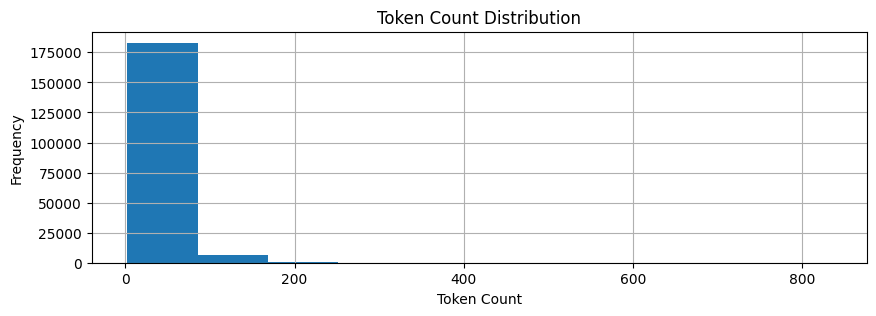

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.title("Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
data['token_count'].hist()

Most of the reviews have less than 100 words, hence further splitting is not required.

In [8]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_community.graphs.graph_document import GraphDocument
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_openai import AzureChatOpenAI

os.environ["AZURE_OPENAI_API_KEY"] = "533894d8f28d4f238f10c0a51a46789e"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://sriks-openai.openai.azure.com/"
os.environ["AZURE_OPENAI_API_VERSION"] = "2024-05-01-preview"
os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT"] = "gpt-4o"

llm = AzureChatOpenAI(
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_deployment=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT"],
)

llm_transformer = LLMGraphTransformer(
    llm=llm,
    node_properties=["description"],
    relationship_properties=["description"]
)     

Extract the entities, relationships from text and create graph

In [9]:
import random
random.seed(42)
# take 25 random rows
ids = random.sample(range(1, len(data)-1), 25)
data = data.iloc[ids]
data.head()

,ProductName,Price,Rate,Review,Summary,token_count
167622,cello Pack of 18 Opalware Cello Dazzle Lush Fi...,"[1, 299]",5,Just wow!,Just wow,39
29185,LA VERNE Microfibre Stripes Cushion Pack of 3Â...,[379],5,Fabulous!,Size is as expected and itâs good quality,31
6557,Cosito 144 TC Cotton Double Floral Flat Bedshe...,[339],4,Very Good,Very good,26
72098,JustandKrafts 75 L Blue Laundry BasketÂ Â Cot...,[298],1,Very poor,Poor product,18
64197,HAIR CARE Triple Blend Damage Repair Non Sti...,[113],5,Wonderful,Really good,38


In [10]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

graph_documents = []
# Convert each row to a Graph Document
# this will take some time 50 rows = 50*3 = 150 requests
# this may fail if token limit is reached
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = [executor.submit(llm_transformer.convert_to_graph_documents, [Document(page_content=f"""You are a data processing assistant, your task is to extract entities, relationships and their labels from product reviews. 
                                                                                     {row['ProductName'], row['Price'], row['Rate']} Review:{row['Review']} Summary:{row['Summary']}. 
                                                                                     """)]) for i, row in data.iterrows()]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Converting to Graph Documents"):
        graph_documents.extend(future.result())
        

Converting to Graph Documents:  76%|███████▌  | 19/25 [02:23<00:39,  6.60s/it]

In [ ]:
# creating graph docs will take time hence saving it to pickle file to load from it in future
# save graph docs to pickle file
import pickle
with open('graph_documents.pkl', 'wb') as f:
    pickle.dump(graph_documents, f)

In [ ]:
graph_documents = pickle.load(open('graph_documents.pkl', 'rb'))

In [ ]:
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

Generate embeddings for the extracted entities

In [ ]:

from langchain_community.vectorstores import Neo4jVector
from langchain_openai import AzureOpenAIEmbeddings

# Create a vector store from the existing graph
vector = Neo4jVector.from_existing_graph(
        AzureOpenAIEmbeddings(),
        node_label='__Entity__',
        text_node_properties=['id', 'description'],
        embedding_node_property='embedding'
)

In [ ]:
from graphdatascience import GraphDataScience

# Create a GraphDataScience instance
# GDS plugin must be installed in the Neo4j instance
gds = GraphDataScience(
    os.environ["NEO4J_URI"],
    auth=(os.environ["NEO4J_USERNAME"], os.environ["NEO4J_PASSWORD"])
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('serverLocation' returned by 'gds.debug.arrow' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.debug.arrow()'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('advertisedListenAddress' returned by 'gds.debug.arrow' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.debug.arrow()'


In [ ]:
similrity_threshold = 0.95
gds.graph.drop("entities")
# exclude the score property from the graph
G, result = gds.graph.project(
    "entities", 
    "__Entity__",
    "*",
    nodeProperties=["embedding"],
    )   

# mutating the graph to add similar relationships

result = gds.knn.mutate(
    G,
    nodeProperties=["embedding"],
    nodeLabels = ["__Entity__"],
    mutateRelationshipType="SIMILAR",
    mutateProperty="score",
    similarityCutoff=similrity_threshold,
)
result.similarityDistribution    
print(result)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.graph.drop($graph_name, $fail_if_missing, $db_name)'


ranIterations                                                             5
nodePairsConsidered                                                   20161
didConverge                                                            True
preProcessingMillis                                                       0
computeMillis                                                           114
mutateMillis                                                             39
postProcessingMillis                                                      0
nodesCompared                                                            73
relationshipsWritten                                                    262
similarityDistribution    {'min': 0.9504585266113281, 'p5': 0.9511604309...
configuration             {'mutateProperty': 'score', 'jobId': '1a4be0ec...
Name: 0, dtype: object


In [ ]:
# writing the graph back to the database
result = gds.knn.write(
    G,
    nodeProperties=["embedding"],
    writeRelationshipType="SIMILAR",
    writeProperty="score",
    similarityCutoff=similrity_threshold,
)
print(f"Number of relationships created: {result.relationshipsWritten}")
print(result)

Number of relationships created: 262
ranIterations                                                             4
didConverge                                                            True
nodePairsConsidered                                                   19258
preProcessingMillis                                                       0
computeMillis                                                            69
writeMillis                                                              14
postProcessingMillis                                                      0
nodesCompared                                                            73
relationshipsWritten                                                    262
similarityDistribution    {'min': 0.9504585266113281, 'p5': 0.9511604309...
configuration             {'writeProperty': 'score', 'writeRelationshipT...
Name: 0, dtype: object


In [ ]:
# get nodes with relationtype as SIMILAR
query = """
MATCH (n:__Entity__)-[r:SIMILAR]-(m:__Entity__)
RETURN n.id as node1, m.id as node2, r.score as score
"""
result = pd.DataFrame.from_records(gds.run_cypher(query))
# exclude numeric types from node 1 and 2
result = result[~result['node1'].str.contains(r'\d')]
result.head()

C:\Users\vism\AppData\Local\Temp\ipykernel_33320\2281118004.py:6: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  result = pd.DataFrame.from_records(gds.run_cypher(query))


,node1,node2,score
0,Review,Review_1,0.950861
1,Review,Review_1,0.950861
28,Nan,5,0.954428
37,Good,5,0.956956
40,Super,5,0.952335


Find similar entities by Levenshtein distance

In [ ]:
import Levenshtein

edit_distance_threshold = 4
query = """
MATCH (n:__Entity__)
RETURN n.id as id, n.wcc as wcc
"""
entities_df = pd.DataFrame.from_records(graph.query(query))
print(f"Number of entities: {entities_df.shape[0]}")
edit_distances = pd.crosstab(entities_df['id'], entities_df['id'])
# fill values with edit distance between column and row names
for i in edit_distances.columns:
    for j in edit_distances.index:
        if len(i) > 4 and len(j) > 4:
            # if i or j has "innings" in it, skip
            edit_distances.loc[j, i] = Levenshtein.distance(i, j)
# find edit distances below threshold and greater than 0
edit_distances = edit_distances[(edit_distances < edit_distance_threshold)]
# create a dictionary of similar entities
edit_distances = edit_distances[edit_distances > 1].stack().to_dict()
edit_distances

Number of entities: 73


{('Review', 'Review_1'): 2.0,
 ('Review_1', 'Review'): 2.0,
 ('Summary', 'Summary_1'): 2.0,
 ('Summary_1', 'Summary'): 2.0}

Merge Entities with low edit distance

In [ ]:
for key, value in edit_distances.items():
    if key[0] != key[1]:
        # merge nodes using  apoc.refactor.mergeNodes(nodes)
        print(f"Merging Nodes {key[0]} and {key[1]} with score {value}")
        merge_query = f"""
        MATCH (n:__Entity__), (m:__Entity__)
        WHERE n.id = '{key[0]}' AND m.id = '{key[1]}' AND n <> m
        CALL apoc.refactor.mergeNodes([n, m]) YIELD node
        RETURN node
        """
        graph.query(merge_query)

Merging Nodes Review and Review_1 with score 2.0
Merging Nodes Review_1 and Review with score 2.0
Merging Nodes Summary and Summary_1 with score 2.0
Merging Nodes Summary_1 and Summary with score 2.0


In [ ]:
G.drop()

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.graph.drop($graph_name, $failIfMissing)'


graphName                                                         entities
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                               73
relationshipCount                                                      335
configuration            {'relationshipProjection': {'__ALL__': {'aggre...
density                                                           0.063737
creationTime                           2024-07-16T07:57:38.577519300+00:00
modificationTime                       2024-07-16T07:57:38.776780500+00:00
schema                   {'graphProperties': {}, 'nodes': {'__Entity__'...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'__Entity__'...
Name: 0, dtype: object

## Identify Graph communities and enhance the knowledge using LLM

In [ ]:
# # Project the graph to create a community graph
gds.graph.drop("communities")
node_properties = ["embedding"]
similarityCutoff = 0.97
topK = 5

G, result = gds.graph.project(
    "communities",  #  Graph name
    "__Entity__",  #  Node projection
    "*",
    nodeProperties=node_properties,
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.graph.drop($graph_name, $fail_if_missing, $db_name)'


In [ ]:
gds.kmeans.stats(G,nodeProperty=node_properties[0],k=topK)

communityDistribution        {'min': 2, 'p5': 2, 'max': 24, 'p999': 24, 'p9...
centroids                    [[-0.0024273318704217672, -0.00438305130228400...
averageDistanceToCentroid                                             0.366477
averageSilhouette                                                          0.0
postProcessingMillis                                                         3
preProcessingMillis                                                          0
computeMillis                                                                6
configuration                {'jobId': '5116329a-2a24-480e-a1d6-df4c6e4830a...
Name: 0, dtype: object

In [ ]:
gds.kmeans.mutate(
    G,
    nodeProperty = node_properties[0],
    mutateProperty = "community",
    k = topK,
)

mutateMillis                                                                 0
nodePropertiesWritten                                                       71
communityDistribution        {'min': 1, 'p5': 1, 'max': 39, 'p999': 39, 'p9...
centroids                    [[-0.0007636715890839696, 0.00843294057995081,...
averageDistanceToCentroid                                             0.368191
averageSilhouette                                                          0.0
postProcessingMillis                                                         4
preProcessingMillis                                                          0
computeMillis                                                                4
configuration                {'mutateProperty': 'community', 'jobId': '7770...
Name: 0, dtype: object

In [ ]:
gds.kmeans.write(
    G,
    nodeProperty = node_properties[0],
    writeProperty = "community",
    k = topK,
)

writeMillis                                                                 16
nodePropertiesWritten                                                       71
communityDistribution        {'min': 1, 'p5': 1, 'max': 30, 'p999': 30, 'p9...
centroids                    [[-0.007178253494203091, -0.004013511352241039...
averageDistanceToCentroid                                             0.370747
averageSilhouette                                                          0.0
postProcessingMillis                                                         2
preProcessingMillis                                                          0
computeMillis                                                                3
configuration                {'writeProperty': 'community', 'jobId': '4ad14...
Name: 0, dtype: object

In [ ]:
# get nodes with writeProperty as community
query = """
MATCH (n:__Entity__)
RETURN n.id as id, n.community as community
"""
result = pd.DataFrame.from_records(gds.run_cypher(query))
result['count'] = result.groupby("community")["id"].transform("count")
result["entities"] = result.groupby("community")["id"].transform(lambda x: ", ".join(x))
# drop id column
result = result.drop(columns=["id"])
result = result.drop_duplicates()
result.head().sort_values(by="count", ascending=False)

C:\Users\vism\AppData\Local\Temp\ipykernel_33320\501766912.py:6: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  result = pd.DataFrame.from_records(gds.run_cypher(query))


,community,count,entities
0,4,30,Home Sizzler 153 Cm 5 02 Ft Polyester Room Dar...
1,2,23,"299, 5, Review 339, 136, Nan, 3, Printed Men T..."
3,0,14,"Brilliant, Superb, 339, Summary 339, Good, Jus..."
51,1,3,"Air_Pin, Quality, Nivia"
11,3,1,Summary_1


In [ ]:
# Lets see the top 5 entities in each community to understand the entities in each community
print(result.iloc[0].entities.split(", ")[:5]) # top 5 entities in community 0, mostly appears to be names of products
print(result.iloc[1].entities.split(", ")[:5]) # top 5 entities in community 1, mostly appears to be names of prices
print(result.iloc[2].entities.split(", ")[:5]) # top 5 entities in community 1, mostly appears to be names of reviews

['Home Sizzler 153 Cm 5 02 Ft Polyester Room Darkening Window Curtain Pack Of 2 Floral Brown', 'Cosito 144 Tc Cotton Double Floral Flat Bedsheet', 'Hold Up Triangle Shape Mobile Holder For Table Desk Pack Of 5 Mobile Holder Mobile Holder', 'Review_1', 'Men Black Sandal']
['299', '5', 'Review 339', '136', 'Nan']
['Brilliant', 'Superb', '339', 'Summary 339', 'Good']


In [ ]:
graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (c:__Community__) REQUIRE c.id IS UNIQUE;")

[]

In [ ]:
# create a node for each community and create a relationship between community and entities
for i, row in result.iterrows():
    community_id = row["community"]
    entities = row["entities"].split(", ")
    query = f"""
    MERGE (c:__Community__{{id: '{community_id}'}})
    WITH c
    UNWIND {entities} as entity
    MATCH (n:__Entity__{{id: entity }})
    MERGE (n)-[:BELONGS_TO]->(c)
    """
    result = graph.query(query)
    print(f"Community {community_id} created with {len(entities)} entities")

Community 2 created with 31 entities
Community 1 created with 37 entities
Community 0 created with 3 entities


In [ ]:
# create summaries for each community
query = """
    MATCH (n:__Entity__)-[:BELONGS_TO]->(c:__Community__)
    with c, collect(n) as nodes
    where size(nodes) > 1
    call apoc.path.subgraphAll(nodes, {limit: 2}) 
    YIELD relationships as rels
    RETURN c.id as community_id
    , 
    [n in nodes | {id: n.id, description: n.description, type: [el in labels(n) where el <> '__Entity__'][0]}] as nodes,
    [r in rels | {start: startNode(r).id, end: endNode(r).id, type: type(r), description: r.description}] as relationships
    """
result = graph.query(query)
print(result[0])

{'community_id': '2', 'nodes': [{'id': 'Nivia Storm Football', 'description': 'Size 5, Pack of 1, Multicolor', 'type': 'Product'}, {'id': 'Cosito 144 Tc Cotton Double Floral Flat Bedsheet', 'description': 'Pack of 1 Red White', 'type': 'Product'}, {'id': 'Mind-Blowing Purchase', 'description': None, 'type': 'Review'}, {'id': 'Cmerchants Book Shelf 5Rack Metal Open Book Shelf', 'description': 'Finish Color BLUE DIY Do It Yourself', 'type': 'Product'}, {'id': 'Pigeon Favourite Electric Kettle 1.5 L Silver Black', 'description': None, 'type': 'Product'}, {'id': 'Review_1', 'description': "Don't waste your money", 'type': 'Concept'}, {'id': 'Very Poor Summary:Poor Product.', 'description': None, 'type': 'Review_summary'}, {'id': 'Review_Summary', 'description': 'Good product ð\x9f\x91\x8d', 'type': 'Summary'}, {'id': 'Best In The Market!', 'description': None, 'type': 'Review'}, {'id': 'Men Black Sandal', 'description': None, 'type': 'Product'}, {'id': 'Summary: One Of The Best Routers I G

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

def get_summary_llm():
    prompt = """Based on the provided nodes and relationships that belong to the same graph community,
generate a natural language summary of the provided information:{community_info} Summary:"""
    community_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Given an input triples, generate the information summary. No pre-amble.",
        ),
        ("human", prompt),
    ])
    community_chain = community_prompt | llm | StrOutputParser()
    return community_chain

community_summaries = {}
for community in result:
    nodes = community["nodes"]
    relationships = community["relationships"]
    community_info = ""
    for node in nodes:
        community_info += f"{node['id']} is a {node['type']} with description {node['description']}. "
    chain = get_summary_llm()
    summary = chain.invoke({'community_info': community_info})
    community_summaries[community["community_id"]] = summary

In [ ]:
community_summaries

{'2': 'This summary describes various products, reviews, and summaries, highlighting their main features and user feedback. \n\n**Products:**\n1. **Nivia Storm Football** - Size 5, Pack of 1, Multicolor.\n2. **Cosito 144 Tc Cotton Double Floral Flat Bedsheet** - Pack of 1, Red and White.\n3. **Cmerchants Book Shelf 5Rack Metal Open Book Shelf** - Finish Color: Blue, DIY.\n4. **Pigeon Favourite Electric Kettle** - 1.5 L, Silver and Black.\n5. **Men Black Sandal** - No description.\n6. **Samsung 253 L Frost Free Double Door 3 Star Refrigerator** - Elegant Inox, RT28A3453S8 HL.\n7. **Hold Up Triangle Shape Mobile Holder For Table Desk** - Pack of 5.\n8. **Home Sizzler 153 Cm 5 02 Ft Polyester Room Darkening Window Curtain** - Pack of 2, Floral Brown.\n9. **Men Lpmxt 800 Grey Clogs Sandal** - Men LPMXT 800 Grey Clogs Sandal.\n10. **Google Nest Mini 2Nd Gen** - Google Assistant Smart Speaker, Chalk.\n11. **Decorum 188 Tc Polycotton Double Floral Flat Bedsheet** - Pack of 1, Multicolor.\n12.

In [ ]:
# merge the summary to the community node
for community_id, summary in community_summaries.items():
    query = """
    MATCH (c:__Community__{id:$community_id})
    SET c.summary = $summary
    """
    result = graph.query(query, params={"community_id": community_id, "summary": summary})
    print(f"Summary added to Community {community_id}")

Summary added to Community 2
Summary added to Community 1
Summary added to Community 0


## Run LLM Queries on graph

In [ ]:
index_name = "document_embeddings"  # default index name
# Create a vector store from the existing graph
graph = Neo4jVector.from_existing_graph(
    AzureOpenAIEmbeddings(),
    node_label='__Entity__',
    text_node_properties=['id', 'description', 'summary', 'community'],
    embedding_node_property='embedding',
    index_name=index_name,
)

In [ ]:
def get_product(query):
   meta = "Given user query: {query} return nodes with similar embeddings, community and id"
   docs_with_score = graph.similarity_search_with_score(query, k=4)
   # get the community and id of the nodes
   # TODO: find a generic way to parse
   product = docs_with_score[0][0].page_content.split("\n")[1]
   product = product.split(":")[1].strip()
   print(product)
   return product

In [ ]:
# get similar products and corresponding reviews relationships
def get_content_by_rel(product):
    query = """
    MATCH (product:__Entity__{id: $product})
    with product
    match (product)-[:SIMILAR]-(similar:__Entity__)
    with product, collect(similar) AS similarEntities
    unwind similarEntities AS similarEntity
    MATCH (similarEntity)<-[r:REVIEW]-(review:Review)
    WITH product, similarEntities, similarEntity, collect({start: similarEntity.id, end: review.id, type: type(r), value: review.description}) AS relationships, 
    collect({product: product.id, similar: similarEntity.id, review: review.description}) AS reviews
    RETURN 
    {id: product.id, description: product.description, type: [label IN labels(product) WHERE label <> '__Entity__'][0]} AS productDetails, reviews,
    [entity IN similarEntities | {id: entity.id, description: entity.description, type: [label IN labels(entity) WHERE label <> '__Entity__'][0]}] AS nodes,
    relationships    
    """
    result = graph.query(query, params={"product": product})
    print(result)
    return result

In [ ]:
import json
query = "recommend a good bedsheet"

def get_recommendation(query):
    product = get_product(query)
    nodes_relationships = get_content_by_rel(product)
    prompt = """Based on the provided context, provide a recommendation based on the provided information. 
    Use description and relationships to provide the recommendation.
    Context:{nodes_relationships}"""
    reco_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a data processing assistant, your task is to provide a recommendation based on the provided information. Be concise and to the point.",
            ),
            ("human", prompt),
        ]
    )
    template = reco_prompt | llm | StrOutputParser()
    result = template.invoke({"nodes_relationships": json.dumps(nodes_relationships)})
    return result
ans = get_recommendation(query)
print("="*50)
print(ans)


Decorum 188 Tc Polycotton Double Floral Flat Bedsheet Pack Of 1 Multicolor
[{'productDetails': {'id': 'Decorum 188 Tc Polycotton Double Floral Flat Bedsheet Pack Of 1 Multicolor', 'description': None, 'type': 'Product'}, 'reviews': [{'product': 'Decorum 188 Tc Polycotton Double Floral Flat Bedsheet Pack Of 1 Multicolor', 'review': 'Waste of money! Summary: very bad 😒.', 'similar': 'Cosito 144 Tc Cotton Double Floral Flat Bedsheet'}, {'product': 'Decorum 188 Tc Polycotton Double Floral Flat Bedsheet Pack Of 1 Multicolor', 'review': 'Waste of money! Summary: very bad 😒.', 'similar': 'Cosito 144 Tc Cotton Double Floral Flat Bedsheet'}], 'nodes': [{'id': 'Cosito 144 Tc Cotton Double Floral Flat Bedsheet', 'description': 'Pack of 1 Red White', 'type': 'Product'}, {'id': 'Cosito 144 Tc Cotton Double Floral Flat Bedsheet', 'description': 'Pack of 1 Red White', 'type': 'Product'}], 'relationships': [{'start': 'Cosito 144 Tc Cotton Double Floral Flat Bedsheet', 'value': 'Waste of money! Summary